# Multi-Task Linear Regression Example

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from sklearn.cluster import KMeans

## MTL LM

In [6]:
class mtl_lm:
    """
    This class defines a multi-task linear model utilizing our "shared+task residual" parameter framework. This can fit linear
        models to any number of tasks. This class uses gradient descent to optimize the models and allows for different learning
        rates to be specified for the shared parameters and for the task specific residual parameters
    """
    def __init__(self, n_expl_vars, n_tasks, lr_shared=0.001, lr_task=0.0001, loss=mse, loss_prime=mse_prime, \
                shared_w_init=[0,0.1],shared_b_init=[0,0.1],task_w_init=[0,0.1],task_b_init=[0,0.1]):

        self.n_expl_vars = n_expl_vars
        self.n_tasks = n_tasks

        self.weights = np.random.normal(shared_w_init[0],shared_w_init[1],size=n_expl_vars)
        self.bias = np.random.normal(shared_b_init[0],shared_b_init[1],size=1)

        self.m_weights = [np.random.normal(task_w_init[0], task_w_init[1], size=n_expl_vars) for t in range(n_tasks)]
        self.m_bias = [np.random.normal(task_b_init[0], task_b_init[1], size=1) for t in range(n_tasks)]

        self.loss = loss
        self.loss_prime = loss_prime

        self.lr_s = lr_shared
        self.lr_t = lr_task

        self.input = None
        self.output = None

    def additive_z(self, x, task_num):
        """
        x - This is a scalar vector of size (n_expl_vars,) corresponding to a single data example
        task_num - This is a scalar corresponding to an example from the task we are currently training/testing on
        This function computes the output of the model given an example input
        """
        self.input = x
        combined_weights = self.weights + self.m_weights[task_num]
        combined_bias = self.bias + self.m_bias[task_num]
        self.output = np.matmul(combined_weights.T,self.input) + combined_bias
        return self.output

    def gradient_descent(self, task_num, loss_prime):
        """
        task_num - This is a scalar corresponding to an example from the task we are currently training on
        loss_prime - This is a scalar corresponding to the derivative of the loss. This value is used in gradient descent 
                    rather than strictly the loss value
        This function computes the gradient descent calculations in order to update the shared parameters and task-residual
            parameters for the task currently being trained
        """
        self.weights -= self.lr_s * self.input * loss_prime
        self.bias -= self.lr_s * loss_prime
        self.m_weights[task_num] -= self.lr_t * self.input * loss_prime
        self.m_bias[task_num] -= self.lr_t * loss_prime

    def fit(self, x_train, y_train, n_iterations, learning_rate=0.001,testing=250):
        """
        x_train - This should be a scalar matrix of size (n_observations,n_expl_vars) representing the explanatory
                    training dataset
        y_train - This should be a scalar matrix of size (n_observations,n_expl_vars) representing the response
                    training dataset
        n_iterations - This should be a scalar that represents how many examples from the training dataset that you train
                        your network on
        learning_rate - This should be a scalar that represents how fast you should update the parameters of your network
        testing - This should be a scalar that represents how frequently you see the efficacy of your network during training
        """
        n_observations = np.shape(x_train)[0]
        mse_scores = []

        for i in range(n_iterations):
            true_vals = []
            predicted_vals = []

            """
            Get a random observation to train through the network
            """
            obs = np.random.randint(0,len(x_train))
            task_num = int(x_train[obs,0])
            x = x_train[obs,1:]
            y = y_train[obs]

            """
            Calculate the predicted value y_hat and obtain error
            """
            output = self.additive_z(x, task_num)

            output_error = self.loss_prime(y, output)

            """
            Update parameters via SGD
            """
            self.gradient_descent(task_num, output_error)

    def print_fits(self, x_max,y_lim=[-5,5]):
        """
        This function prints model parameters and plot lines
        """
        
        print("Shared slope: ",self.weights, "\ttask specific delta slope: ",self.m_weights)
        print("Shared bias: ",self.bias, "\ttask specific delta bias: ", self.m_bias)
        print("\n")
        for t in range(self.n_tasks):
            print("Task",t,"| \tSlope: ",self.weights+self.m_weights[t], "\tBias: ",self.bias+self.m_bias[t])
        print("Shared | \tSlope: ",self.weights, "\tBias: ",self.bias)

        x_linspace = np.linspace(0, x_max, x_max*10 +1)
        ti_yhats = [(self.weights + self.m_weights[t]) * x_linspace + (self.bias + self.m_bias[t]) for t in range(self.n_tasks)]
        t0_yhat = (self.weights) * x_linspace + (self.bias)

        for t in range(self.n_tasks):
            plt.plot(x_linspace,ti_yhats[t],label="Task "+str(t))
        plt.plot(x_linspace,t0_yhat, label="Shared")

        plt.xlim([0,x_max])
        plt.ylim(y_lim)

        plt.legend()
            

In [75]:
class gmtl_lm(mtl_lm):
    def __init__(self, n_expl_vars, n_tasks, lr_shared=0.001, lr_task=0.0001, loss=mse, loss_prime=mse_prime, \
                shared_w_init=[0,0.1],shared_b_init=[0,0.1],task_w_init=[0,0.1],task_b_init=[0,0.1]):
        mtl_lm.__init__(self,n_expl_vars,n_tasks,lr_shared,lr_task,loss,loss_prime,shared_w_init,shared_b_init,task_w_init,task_b_init)
        self.groupings = [0 for t in range(self.n_tasks)]
        self.weights = [self.weights] # turn to lists for grouping index
        self.bias = [self.bias]

    def additive_z(self, x, task_num):
        """
        x - This is a scalar vector of size (n_expl_vars,) corresponding to a single data example
        task_num - This is a scalar corresponding to an example from the task we are currently training/testing on
        This function computes the output of the model given an example input
        """
        self.input = x
        combined_weights = self.weights[self.groupings[task_num]] + self.m_weights[task_num]
        combined_bias = self.bias[self.groupings[task_num]] + self.m_bias[task_num]
        self.output = np.matmul(combined_weights.T,self.input) + combined_bias
        return self.output

    def gradient_descent(self, task_num, loss_prime):
        """
        task_num - This is a scalar corresponding to an example from the task we are currently training on
        loss_prime - This is a scalar corresponding to the derivative of the loss. This value is used in gradient descent 
                    rather than strictly the loss value
        This function computes the gradient descent calculations in order to update the shared parameters and task-residual
            parameters for the task currently being trained
        """
        self.weights[self.groupings[task_num]] -= self.lr_s * self.input * loss_prime
        self.bias[self.groupings[task_num]] -= self.lr_s * loss_prime
        self.m_weights[task_num] -= self.lr_t * self.input * loss_prime
        self.m_bias[task_num] -= self.lr_t * loss_prime


    def update_rules(self, old_groupings):
        for l, shared_l in enumerate(self.weights):
            """
            Get tasks for group l
            """
            print("getting groups for ",l)
            G = []
            for i,group_i in enumerate(self.groupings):
                print(i,group_i)
                if group_i == l:
                    G.append(i)
            # G = [i for i,group_i in enumerate(self.groupings) if group_i == l]
            print("finished getting groups")
            """
            Update the shared params for group l
            """
            print("G",G, len(G))
            print("got to first update")
            old_weights = self.weights.copy()
            old_bias = self.bias.copy()

            self.weights[l] = 1/len(G) * np.sum([self.weights[old_groupings[j]]+self.m_weights[j] for j in G])
            self.bias[l] = 1/len(G) * np.sum([self.bias[old_groupings[j]]+self.m_bias[j] for j in G])
            """
            Update the delta params for each task in group l
            """
            print("got to second update")
            for j in G:
                self.m_weights[j] = old_weights[old_groupings[j]] + self.m_weights[j] - self.weights[l]
                self.m_bias[j] = old_bias[old_groupings[j]] + self.m_bias[j] - self.bias[l]

        
        print("After group shifts")
        print(self.weights)
        print(self.bias)
        print(self.m_weights)
        print(self.m_bias)


    def change_groups(self):
        """
        Convert the parameters into matrix form that can be used on kmeans
        """
        print("got to clusters")
        cluster_data = np.zeros((self.n_tasks,self.n_expl_vars+1))
        for t in range(self.n_tasks):
            cluster_data[t,0] = self.bias[self.groupings[t]]+self.m_bias[t]
            cluster_data[t,1:] = self.weights[self.groupings[t]]+self.m_weights[t]
        

        """
        Identify the new groups using kmeans
        """
        print("got to kmeans")
        print(cluster_data)
        print("weights",self.weights,self.m_weights)
        print("biases",self.bias,self.m_bias)

        #simply choose number of groups to be one larger before change_groups was called up until there's a group for every 2 tasks
        n_groups = int(min(len(np.unique(self.groupings))+1,np.floor(self.n_tasks/2)))
        #I'd like to make n_groups dynamic based on some clustering metric

        new_groupings = KMeans(n_clusters=n_groups, random_state=0, n_init="auto").fit_predict(cluster_data)
        old_groupings = self.groupings
        self.groupings = list(np.array(new_groupings))

        print("groupings",self.groupings)
        
        """
        Update the parameters with the new groups
        """
        print("got to update call")

        if n_groups != len(self.weights):
            self.weights.append(None)
            self.bias.append(None)

        self.update_rules(old_groupings)


    def eval_groups(self):
        """
        Has very simple evaluation rule
        """
        for t in range(self.n_tasks):
            task_separation = abs(self.m_weights[t]) + abs(self.m_bias[t])
            if (task_separation > self.split_threshold): #and not (max(self.groupings)+1 == np.floor(self.n_tasks/2)):
                self.change_groups()


    def fit(self, x_train, y_train, n_iterations, split_threshold, learning_rate=0.001,testing=250):
        """
        x_train - This should be a scalar matrix of size (n_observations,n_expl_vars) representing the explanatory
                    training dataset
        y_train - This should be a scalar matrix of size (n_observations,n_expl_vars) representing the response
                    training dataset
        n_iterations - This should be a scalar that represents how many examples from the training dataset that you train
                        your network on
        learning_rate - This should be a scalar that represents how fast you should update the parameters of your network
        testing - This should be a scalar that represents how frequently you see the efficacy of your network during training
        """
        self.split_threshold = split_threshold
        n_observations = np.shape(x_train)[0]
        mse_scores = []

        for i in range(n_iterations):
            true_vals = []
            predicted_vals = []

            """
            Get a random observation to train through the network
            """
            obs = np.random.randint(0,len(x_train))
            task_num = int(x_train[obs,0])
            x = x_train[obs,1:]
            y = y_train[obs]

            """
            Calculate the predicted value y_hat and obtain error
            """
            output = self.additive_z(x, task_num)

            output_error = self.loss_prime(y, output)

            """
            Update parameters via SGD
            """
            self.gradient_descent(task_num, output_error)

            """
            Evaluate Groupings
            """
            self.eval_groups()

        print("before last update")
        print(self.weights)
        print(self.bias)
        print(self.m_weights)
        print(self.m_bias)
        
        self.update_rules(self.groupings)


    def print_fits(self, x_max,y_lim=[-5,5]):
        """
        This function prints model parameters and plot lines
        """
        
        print("Shared slope: ",self.weights, "\ttask specific delta slope: ",self.m_weights)
        print("Shared bias: ",self.bias, "\ttask specific delta bias: ", self.m_bias)
        print("\n")
        for t in range(self.n_tasks):
            print("Task",t,"| \tSlope: ",self.weights[self.groupings[t]]+self.m_weights[t], "\tBias: ",self.bias[self.groupings[t]]+self.m_bias[t])
        for k in range(len(self.weights)):
            print("Shared",k,"| \tSlope: ",self.weights[k], "\tBias: ",self.bias[k])

        x_linspace = np.linspace(0, x_max, x_max*10 +1)
        ti_yhats = [(self.weights[self.groupings[t]] + self.m_weights[t]) * x_linspace + (self.bias[self.groupings[t]] + self.m_bias[t]) for t in range(self.n_tasks)]
        t0_yhats = [(self.weights[k]) * x_linspace + (self.bias[k]) for k in range(len(self.weights))]

        for t in range(self.n_tasks):
            plt.plot(x_linspace,ti_yhats[t],label="Task "+str(t))
        for k in range(len(self.weights)):
            plt.plot(x_linspace,t0_yhats[k], label="Shared "+str(k))

        plt.xlim([0,x_max])
        plt.ylim(y_lim)

        plt.legend()
        

## Data

In [8]:
class Data:
    """
    This class generates linear data for an arbitrary number of tasks. We can specify unique slope, bias (y-intercept) and noise (gaussian
        noise on the y value) parameters for each task. We can also change the maximum x value and number of samples for all tasks
    """
    def __init__(self, n_samples=100, n_tasks=2, ti_slopes=[0.5,0.5], ti_biases=[0,4], ti_noises=[0.25,0.25], x_max=10):
        self.n_samples = n_samples
        self.n_tasks = n_tasks
        self.ti_slope = ti_slopes
        self.ti_bias = ti_biases
        self.ti_noise = ti_noises
        self.x_max = x_max

        """
        Randomly select x values for all the tasks to use. Values span [0,x_max]
        """
        self.x_vals = x_max*np.random.random(n_samples)
        
        """
        Generate x data used by the mtl_lm class
        """
        self.task_nums = np.array(np.concatenate([t*np.ones(n_samples) for t in range(self.n_tasks)]))
        self.x_data = np.column_stack((self.task_nums,np.array(np.concatenate([self.x_vals for t in range(self.n_tasks)]))))
        
        """
        Generate y data used by the mtl_lm class
        """
        self.ti_y = [self.ti_bias[t] + self.ti_slope[t]*self.x_vals + np.random.normal(0,self.ti_noise[t],n_samples) for t in range(self.n_tasks)]
        self.y_data = np.array(np.concatenate([tiy_data for tiy_data in self.ti_y]))

    def print_data(self, y_lim=[-5,5]):
        """
        This function prints the data points for each class
        """
        for t in range(self.n_tasks):
            plt.scatter(self.x_vals,self.ti_y[t])
        
        plt.xlim([0,self.x_max])
        plt.ylim(y_lim)
        

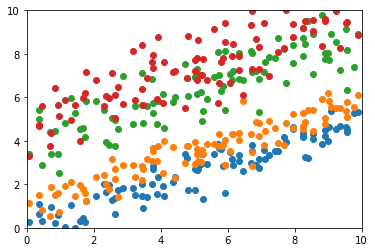

In [9]:
data = Data(100,4,[0.5,0.5,0.5,0.5],[0,1,4,5],[0.5,0.5,1,1],10)
data.print_data(y_lim=[0,10])

## Testing

### main

got to clusters
got to kmeans
[[3.0899525  0.06774676]
 [3.46869494 0.16952376]
 [3.96796051 0.51994933]
 [4.10315931 0.6277984 ]
 [4.77423997 0.8237594 ]
 [5.00849822 0.95155598]]
weights [array([0.56194209])] [array([-0.49419533]), array([-0.39241834]), array([-0.04199276]), array([0.0658563]), array([0.2618173]), array([0.38961389])]
biases [array([3.89784507])] [array([-0.80789256]), array([-0.42915012]), array([0.07011545]), array([0.20531425]), array([0.87639491]), array([1.11065315])]
groupings [1, 1, 1, 0, 0, 0]
got to update call
getting groups for  0
0 1
1 1
2 1
3 0
4 0
5 0
finished getting groups
G [3, 4, 5] 3
got to first update
got to second update
getting groups for  1
0 1
1 1
2 1
3 0
4 0
5 0
finished getting groups
G [0, 1, 2] 3
got to first update
got to second update
After group shifts
[0.801037924846154, 0.49150244783860275]
[4.628632502794179, 4.239656755665128]
[array([-0.18465985]), array([-0.08288286]), array([0.26754272]), array([-0.17323953]), array([0.02272147]

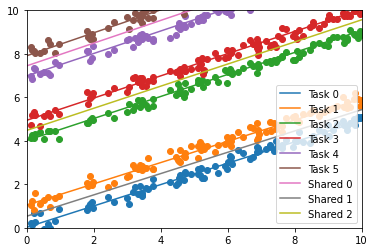

In [76]:
"""
Define hyper parameters
"""
n_expl_vars = 1
n_tasks = 6
n_iterations = 400000
n_samples = 100
x_max = 10
y_lim = [0,10]

"""
Generate data
"""
data = Data(n_samples,n_tasks,ti_slopes=[0.5,0.5,0.5,0.5,0.5,0.5],ti_biases=[0,1,4,5,7,8],ti_noises=[0.2,0.2,0.2,0.2,0.2,0.2],x_max=x_max)

"""
Initialize and fit model
"""
linear_model = gmtl_lm(n_expl_vars, n_tasks, lr_shared=0.0025,lr_task=0.0005,\
    shared_w_init=[0,0.1],shared_b_init=[0,0.1],task_w_init=[0,0.1],task_b_init=[0,0.1])
linear_model.fit(data.x_data, data.y_data, n_iterations, split_threshold=1.5)

"""
Print results
"""
linear_model.print_fits(x_max=x_max,y_lim=y_lim)
data.print_data(y_lim=y_lim)

### Example 2d data

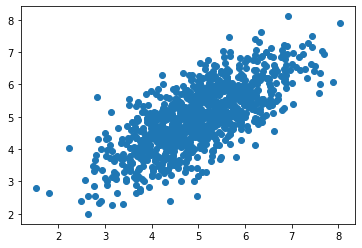

In [59]:
task1_mean = [5,5]
task1_cov = [[1, 0.7],[0.7, 1]]
task1_data = np.random.multivariate_normal(task1_mean, task1_cov, 1000)
plt.scatter(task1_data[:,0],task1_data[:,1])

## Comparison to Closed-Form Solution (Old Code)

In [60]:
bias_term = np.array(list(np.ones((n_samples,))) + list(np.ones((n_samples,))))

x = np.column_stack((bias_term,x_))
y = y_
x = np.reshape(x, (len(x),2))
y = np.reshape(y, (len(y),1))

NameError: name 'x_' is not defined

[[3.83843657]
 [0.52898793]]
[[2.07708001]
 [0.5076741 ]]
[[5.60958592]
 [0.54831143]]


(0.0, 10.0)

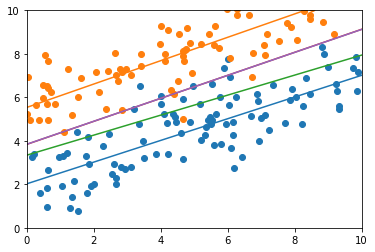

In [ ]:
b = np.linalg.inv(x.transpose().dot(x)).dot(x.transpose()).dot(y)
print(b)
b_yhat = (b[1]) * x_linspace + (b[0])

bias_term = np.ones((n_samples,))
x = np.column_stack((bias_term,t1_x))
x = np.reshape(x, (len(x),2))
y = np.reshape(t1_y, (len(t1_y),1))

b1 = np.linalg.inv(x.transpose().dot(x)).dot(x.transpose()).dot(y)
print(b1)
b1_yhat = (b1[1]) * x_linspace + (b1[0])

x = np.column_stack((bias_term,t2_x))
x = np.reshape(x, (len(x),2))
y = np.reshape(t2_y, (len(t2_y),1))

b2 = np.linalg.inv(x.transpose().dot(x)).dot(x.transpose()).dot(y)
print(b2)
b2_yhat = (b2[1]) * x_linspace + (b2[0])

bnew = np.mean([b1,b2],0)
bnew_yhat = (bnew[1]) * x_linspace + (bnew[0])

plt.scatter(t1_x,t1_y)
plt.scatter(t2_x,t2_y)
plt.plot(x_linspace, t1_yhat)
plt.plot(x_linspace, t2_yhat)
plt.plot(x_linspace,t0_yhat)
plt.plot(x_linspace,b_yhat)
plt.plot(x_linspace,bnew_yhat)

plt.xlim([0,10])
plt.ylim([0,10])